# Linear Regression with UCI Dataset

In [2]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from LAGS import LAGS, adaptive_LAGS
from metric import winning_rate

from ucimlrepo import fetch_ucirepo

In [3]:
ks = list(range(1, 101, 3)) + [100]
methods = ["LAGS", "Adaptive LAGS"]
UCI_id = 165
test_size = 50
num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)

In [4]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(UCI_dataset.data.targets)

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

n_train = len(Y) - test_size

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

Shape of features: (1030, 8)
Shape of labels: (1030, 1)


In [5]:
def actual_effect(X_train, Y_train, x_test, subset_to_remove, original_value):
    reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
    reduced_Y_train = np.delete(Y_train, subset_to_remove, axis=0)

    lr = LinearRegression().fit(reduced_X_train, reduced_Y_train)
    reduced_value = lr.predict(x_test.reshape(1, -1))

    return reduced_value - original_value

In [6]:
def score(i_th_test, k):
    x_test = X_test[i_th_test]
    lr = LinearRegression().fit(X_train, Y_train)
    original_value = lr.predict(x_test.reshape(1, -1))

    scores = np.array([
        actual_effect(X_train, Y_train, x_test, LAGS(X_train, Y_train, x_test)[:k], original_value),
        actual_effect(X_train, Y_train, x_test, adaptive_LAGS(X_train, Y_train, x_test, k=k), original_value),
    ])

    return scores

In [7]:
scores_array = np.array(Parallel(n_jobs=50)(delayed(score)(i, k) for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo
scores_ks_method = scores_ks_method_combo.mean(axis=2)

In [8]:
palette = sns.color_palette("bright")
colors = [palette[9], palette[1]]

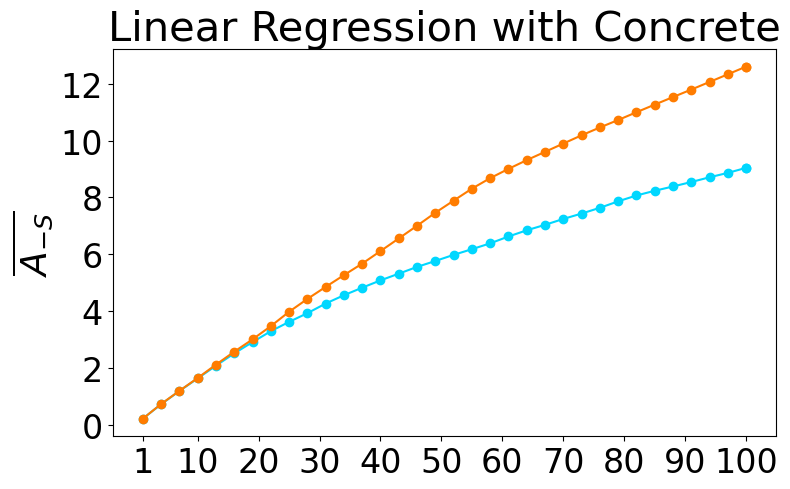

In [10]:
plt.figure(figsize=(8, 5))  # Create a single plot

plt.title(f'Linear Regression with Concrete', fontsize=30)

# plt.xlabel('$k$', fontsize=24)
plt.ylabel('$\overline{A_{-S}}$', fontsize=26)

for method_idx, method_name in enumerate(methods):
     plt.plot(ks, scores_ks_method[:, method_idx], marker='o', label=method_name, color=colors[method_idx])

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1), fontsize=24)
plt.yticks(fontsize=24)

# plt.legend(methods, fontsize=22)

plt.tight_layout()

plt.savefig('../Figures/Linear_Regression_uci_actual.png', format='png', dpi=300)

plt.show()

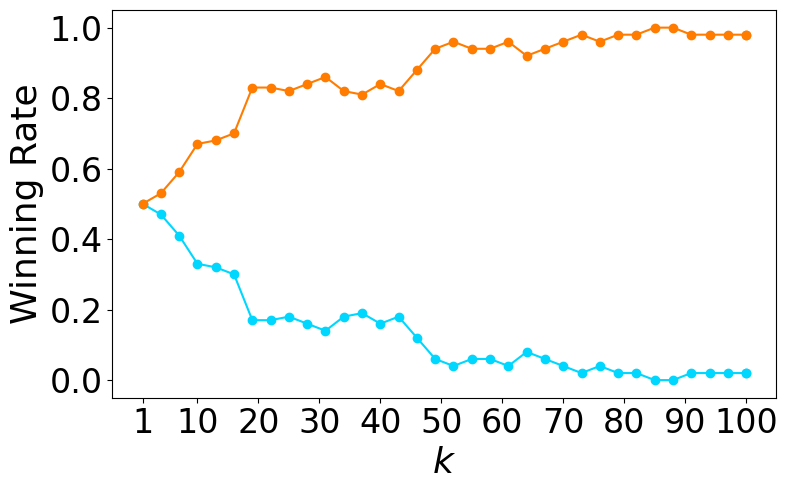

In [11]:
winning_result = np.array(Parallel(n_jobs=50)(delayed(winning_rate)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

plt.figure(figsize=(8, 5))

# plt.title(f'Linear Regression with Concrete', fontsize=26)

plt.xlabel('$k$', fontsize=26)
plt.ylabel('Winning Rate', fontsize=26)

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, winning_result[:, method_idx], marker='o', label=method_name, color=colors[method_idx])

plt.yticks(fontsize=24)
plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1), fontsize=24)

# plt.legend(methods, fontsize=22)

plt.tight_layout()

plt.savefig('../Figures/Linear_Regression_uci_winning.png', format='png', dpi=300)

plt.show()